In [1]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

filename = "output/msource_value_dic_12-16-2022-23-49-17.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),

#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

In [2]:
if 'pol_dic' in output_obj: 
    output_obj['pol_dic']
    action = eval_policy_from_policy_dic(sourcingEnv2, pol_dic = output_obj['pol_dic'])
    action

In [3]:
sourcingEnv2.lambda_arrival

50

In [4]:
model_params["branch_name"], model_params["git_commit"]

('larkin/unif', '15e93c3ab603f45074af3321342fc1af0c715be9')

In [5]:
# sourcingEnv2.lambda_arrival = 100
kwargs = {"periods" : 60,
    "nested_mc_iters" : 5,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty" : model_params['policy_params']['b_penalty'],
    "supplier_index": 1,
    "h_cost": 2,
    "b_penalty": 10
}

In [6]:
dummy_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        periods = 100,
        nested_mc_iters = 30,
        big_s = model_params['policy_params']['big_s'],
        small_s = model_params['policy_params']['small_s'],
        h_cost = model_params['policy_params']['h_cost'],
        b_penalty = model_params['policy_params']['b_penalty'],
        max_order = 6, # BIG_S,
        policy_callback=dummy_explore_policy,
        use_tqdm = True
    )

print(np.mean(dummy_cost))
print(np.median(np.array(dummy_cost)))
print(np.std(np.array(dummy_cost)))

100%|██████████| 30/30 [00:02<00:00, 14.79it/s]

5.201611725182951
5.236707243468038
1.0602028609009886


In [7]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 6, # BIG_S,
    policy_callback=dual_index_policy,
    use_tqdm = True
)


print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

  3%|▎         | 1/30 [00:00<00:15,  1.93it/s]/home/larkin/code/multi-sourcing-inventory/sim/policies.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 30/30 [00:50<00:00,  1.69s/it]

4.557806051049503
4.531687087419922
0.7567553029565711


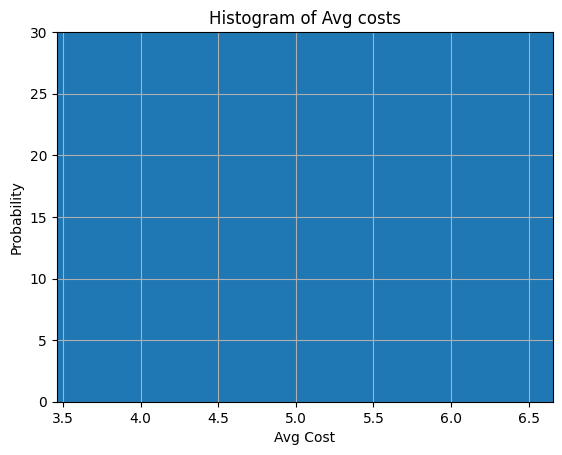

In [8]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange( np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [9]:
# sourcingEnv2.lambda_arrival = 50
# sourcingEnv2.supplier_lead_times_vec = np.array([0.008, 0.04])

model_params['mdp_env_params']

{'lambda': 50,
 'max_inven': 30,
 'action_size': 3,
 'discount_fac': 1.0,
 'procurement_cost_vec': [15, 5],
 'supplier_lead_times_vec': [0.036, 0.4],
 'on_times': [5, 1],
 'off_times': [0.5, 1],
 'fixed_costs': [0, 0]}

In [10]:
# output_obj['adp_cost'], output_obj['approx_di_cost'], output_obj['ss_cost']

In [11]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

100%|██████████| 100/100 [00:06<00:00, 15.09it/s]

5.9348490660145305
5.5547442282268875
1.5845805257295937


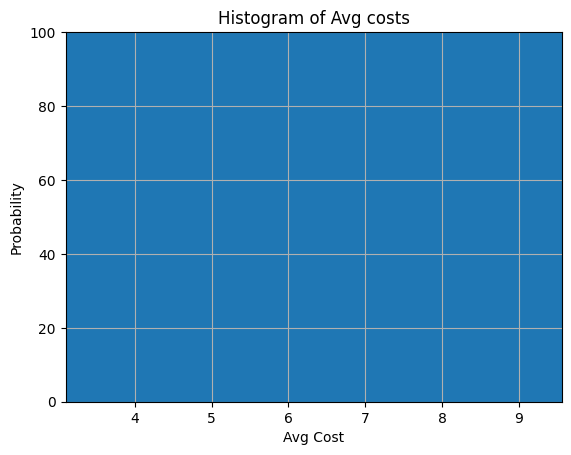

In [12]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_ss, bins=np.arange( np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [13]:
# import matplotlib.pyplot as plt

# costs, avg_cost_per_period = mc_episode_with_policy(sourcingEnv2, policy = ss_policy_fastest_supp_backlog, periods = 1000,
#     nested_mc_iters = 100,
#     policy_callback = ss_policy_fastest_supp_backlog,
#     big_s = model_params['policy_params']['big_s'],
#     small_s = model_params['policy_params']['small_s'],
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'],
#     use_tqdm = True)

# # costs
# plt.plot(costs)

In [14]:
single_supplier_mean_costs = []
sing_supp_mean_cost = np.Inf
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : 100,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    sing_supp_mean_cost_i = np.mean(single_supplier_costs)
    single_supplier_mean_costs.append(sing_supp_mean_cost_i)
    if sing_supp_mean_cost_i < sing_supp_mean_cost:
        single_supplier_costs_select = single_supplier_costs
        sing_supp_mean_cost = sing_supp_mean_cost_i

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

100%|██████████| 100/100 [00:07<00:00, 13.82it/s]

[6.890365705130499, 4.868505188454022]
4.868505188454022


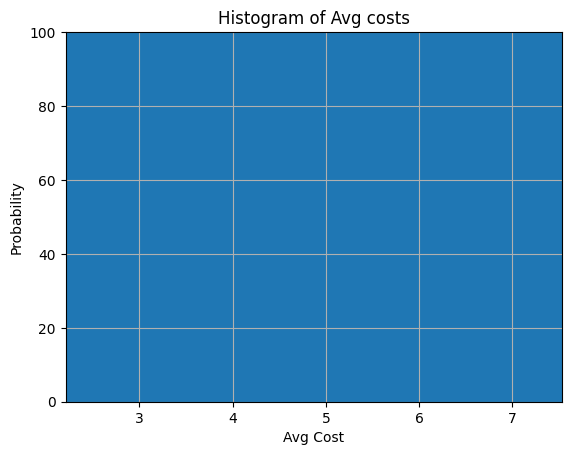

In [15]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(single_supplier_costs_select, bins=np.arange( np.min(single_supplier_costs_select), np.max(single_supplier_costs_select) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(single_supplier_costs_select), np.max(single_supplier_costs_select))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [16]:
from sim.dual_index_v1 import *
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy_v1,
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

 77%|███████▋  | 23/30 [00:01<00:00, 12.26it/s]/home/larkin/code/multi-sourcing-inventory/sim/dual_index_v1.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 30/30 [00:02<00:00, 12.38it/s]

6.247495817477187
5.32014823324217
2.247965071847457


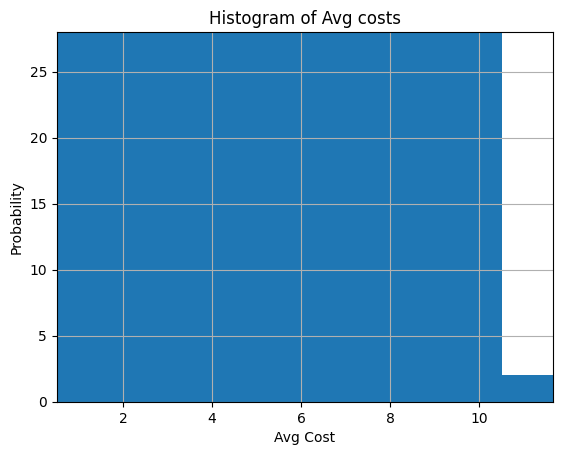

In [17]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [18]:
myopic_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 3,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 6, # BIG_S,
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_cost))
print(np.median(np.array(myopic_cost)))
print(np.std(np.array(myopic_cost)))

100%|██████████| 3/3 [04:42<00:00, 94.25s/it]

4.050380668814505
2.530055982108394
2.7895378388486987


In [19]:
myopic_cost

[2.530055982108394, 1.6579660239249299, 7.963120000410191]

In [20]:
kwargs = {
    "value_dic": value_dic, 
    "periods": 100, 
    "periods_val_it": 30,
    "nested_mc_iters": 3,
    "max_stock": 3, # BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": 1.1, #SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True,
    "pol_dic": output_obj['pol_dic']
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_policy_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))



KeyError: 'pol_dic'

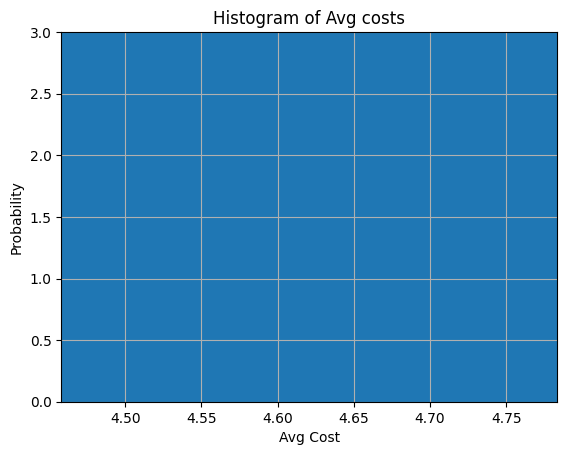

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(myopic_cost, bins=np.arange( np.min(myopic_cost), np.max(myopic_cost) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(myopic_cost), np.max(myopic_cost))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [22]:
kwargs = {
    "value_dic": value_dic, 
    "periods": 20, 
    "periods_val_it": 30,
    "nested_mc_iters": 3,
    "max_stock": 3, # BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": 1.1, #SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_value_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
mc_avg_costs

[7.413420607935275, 6.61504710091386, 8.824472548156855]

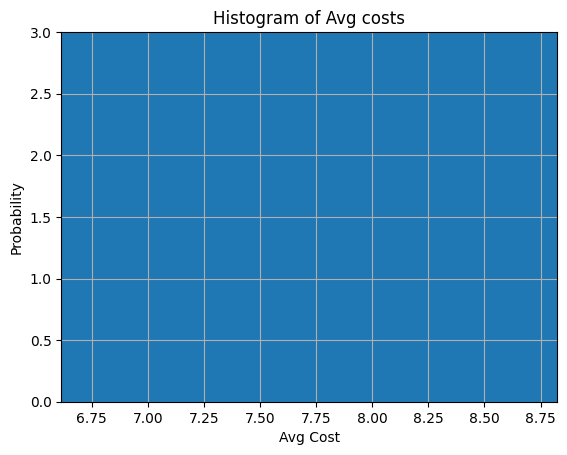

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs) - binwidth, np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()